In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from typing import Optional
from typing import Union
from typing import Tuple
from typing import List

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])
train_dataset = MNIST(root='/content/drive/MyDrive/difussion/data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='/content/drive/MyDrive/difussion/data', train=False, transform=transform, download=True)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


DenoiseDifussion Model

In [7]:
class Tools:
    def gather(self, consts: torch.Tensor, t: torch.Tensor):
        c= consts.gather(-1, t)
        return c.reshape(-1, 1, 1, 1)

In [8]:
import torch.nn.functional as F
import torch.nn as nn
class DenoiseDiffusion:
  def __init__(self, eps_model, n_step, device):
    super().__init__()
    self.eps_model = eps_model
    self.beta = torch.linspace(1e-4, 0.02, n_step).to(device)
    self.alpha = 1. - self.beta
    self.alpha_bar = torch.cumprod(self.alpha, dim=0)
    self.n_step = n_step
    self.sigma2 = self.beta
    self.tools = Tools()

  def q_xt_x0(self, x0, t):
    alpha_bar_t = self.tools.gather(self.alpha_bar, t)
    mean = alpha_bar_t ** 0.5 * x0
    var = 1 - alpha_bar_t
    return mean, var

  def q_sample(self, x0, t, eps):
    if eps is None:
      eps = torch.randn_like(x0)
    mean, var = self.q_xt_x0(x0, t)
    return mean + torch.sqrt(var) * eps

  def p_sample(self, xt, t):
    eps_theta = self.eps_model(xt, t)
    alpha_bar_t = self.tools.gather(self.alpha_bar, t)
    alpha_t = self.tools.gather(self.alpha, t)
    eps_coef = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
    mean = 1 / torch.sqrt(alpha_t) * (xt - eps_coef * eps_theta)
    var = self.tools.gather(self.sigma2, t)
    eps = torch.randn(xt.shape, device=xt.device)
    return mean + torch.sqrt(var) * eps

  def loss(self, x0, noise=None):
    batch_size = x0.shape[0]
    t = torch.randint(0, self.n_step, (batch_size,), device=x0.device, dtype=torch.long)
    if noise is None:
      noise = torch.randn_like(x0)
    xt = self.q_sample(x0, t, eps=noise)
    # print(f"t:{t}, {t.shape}, xt:{xt.shape}")
    eps_theta = self.eps_model(xt, t)
    return F.mse_loss(noise, eps_theta)


U-Net for Denoising Diffusion Probabilistic Models
(DDPM)

In [9]:
!pip install labml_helpers
from labml_helpers.module import Module

class Swish(Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 5.8 MB/s eta 0:00:00


Embeddings for t


In [10]:
import math
class TimeEmbedding(nn.Module):
  def __init__(self, n_channels):
    super().__init__()
    self.n_channels = n_channels
    self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
    self.act = Swish()
    self.lin2 = nn.Linear(self.n_channels, self.n_channels)

  def forward(self, t):
    # create sinusoidal position embeddings same as those from Transformer
    half_dim = self.n_channels // 8
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
    emb = t[:, None] * emb[None, :]
    emb = torch.cat((emb.sin(), emb.cos()), dim=1)

    emb = self.act(self.lin1(emb))
    emb = self.lin2(emb)
    return emb


**Residual Block**:
A residual block has 2 conv layers with group normalization.


In [11]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, time_channels, n_groups=16, droupout=0.1):
    super().__init__()
    self.norm1 = nn.GroupNorm(n_groups, in_channels)
    self.act1 = Swish()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    self.norm2 = nn.GroupNorm(n_groups, out_channels)
    self.act2 = Swish()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels != out_channels:
      self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    else:
      self.shortcut = nn.Identity()

    self.time_emb = nn.Linear(time_channels, out_channels)
    self.time_act = Swish()

    self.dropout = nn.Dropout(droupout)
  def forward(self, x, t):
    h = self.conv1(self.act1(self.norm1(x)))
    h += self.time_emb(self.time_act(t))[:, :, None, None]
    h = self.conv2(self.dropout(self.act2(self.norm2(h))))
    return h + self.shortcut(x)


Attention Block
- n_channels: num of channels in inputs
- n_heads: num of heads in multi-head attention
- d_k: num of dim in each head
- n_group: num of groups for group norm

In [12]:
class AttentionBlock(nn.Module):
  def __init__(self, n_channels, n_heads=1, d_k=None, n_groups=16):
    super().__init__()
    if d_k is None:
      d_k = n_channels
    self.norm = nn.GroupNorm(n_groups, n_channels)
    self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
    self.output = nn.Linear(n_heads * d_k, n_channels)
    self.scale = d_k ** -0.5

    self.n_heads = n_heads
    self.d_k = d_k

  def forward(self, x, t:Optional[torch.Tensor]=None):
    # t is unnecessary
    _ = t
    batch_size, n_channels, H, W = x.shape
    x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
    qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
    q, k, v = torch.chunk(qkv, 3, dim=-1)
    # print(f"q:{q.shape}, k:{k.shape}, v:{v.shape}")
    attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
    attn = attn.softmax(dim=2)
    # print(f"atten:{attn.shape}")
    res = torch.einsum('bijh,bjhd->bihd', attn, v)
    res = res.view(batch_size, -1, self.n_heads*self.d_k)
    res = self.output(res)
    res += x
    res = res.permute(0, 2, 1).view(batch_size, n_channels, H, W)
    return res


In [13]:
class DownBlock(nn.Module):
  def __init__(self, in_channels, out_channels, time_channels, has_attn):
    super().__init__()
    self.res = ResidualBlock(in_channels, out_channels, time_channels)
    if has_attn:
      self.attn = AttentionBlock(out_channels)
    else:
      self.attn = nn.Identity()
  def forward(self, x, t):
    x = self.res(x, t)
    x = self.attn(x)
    return x

In [14]:
class UpBlock(nn.Module):
  def __init__(self, in_channels, out_channels, time_channels, has_attn):
    super().__init__()
    self.res = ResidualBlock(in_channels+out_channels, out_channels, time_channels)
    if has_attn:
      self.attn = AttentionBlock(out_channels)
    else:
      self.attn = nn.Identity()

  def forward(self, x, t):
    x = self.res(x, t)
    x = self.attn(x)
    return x


In [15]:
class MiddleBlock(nn.Module):
  def __init__(self, n_channels, time_channels):
    super().__init__()
    self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
    self.attn = AttentionBlock(n_channels)
    self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

  def forward(self, x, t):
    x = self.res1(x, t)
    x = self.attn(x)
    x = self.res2(x, t)
    return x

In [16]:
class UpSample(nn.Module):
  def __init__(self, n_channels):
    super().__init__()
    self.conv = nn.ConvTranspose2d(n_channels, n_channels, kernel_size=4, stride=2, padding=1)

  def forward(self, x, t):
    return self.conv(x)

In [17]:
class DownSample(nn.Module):
  def __init__(self, n_channels):
    super().__init__()
    self.conv = nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=2, padding=1)

  def forward(self, x, t):
    return self.conv(x)

In [18]:
class UNet(nn.Module):
  def __init__(self, image_channels, n_channels, ch_mults, is_attn, n_blocks):
    super().__init__()
    n_resolutions = len(ch_mults)
    self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=3, padding=1)
    self.time_emb = TimeEmbedding(n_channels*4)
    down = []
    in_channels = n_channels
    out_channels = n_channels
    # resolution是什么意思？
    for i in range(n_resolutions):
      print(f"i = {i}, ch_mult = {ch_mults[i]}")
      out_channels = in_channels * ch_mults[i]
      print(f"out_channels:{out_channels}")
      for _ in range(n_blocks):
        down.append(DownBlock(in_channels, out_channels, n_channels*4, is_attn[i]))
        in_channels = out_channels
      if i < n_resolutions - 1:
        print(f"inchannels:{in_channels}")
        down.append(DownSample(in_channels))
    self.down = nn.ModuleList(down)
    self.middle = MiddleBlock(out_channels, n_channels * 4)
    up = []
    in_channels = out_channels
    for i in reversed(range(n_resolutions)):
      out_channels = in_channels
      for _ in range(n_blocks):
        up.append(UpBlock(in_channels, out_channels, n_channels*4, is_attn[i]))
      out_channels = in_channels // ch_mults[i]
      up.append(UpBlock(in_channels, out_channels, n_channels*4, is_attn[i]))
      in_channels = out_channels
      if i > 0:
        up.append(UpSample(in_channels))
    self.up = nn.ModuleList(up)
    self.norm = nn.GroupNorm(8, n_channels)
    self.act = Swish()
    self.final = nn.Conv2d(in_channels, image_channels, kernel_size=3, padding=1)

  def forward(self, x, t):
    t = self.time_emb(t)
    x = self.image_proj(x)

    h = [x]

    for m in self.down:
      # print(x.shape)
      x = m(x, t)
      h.append(x)
    # print('---')
    x = self.middle(x, t)
    for m in self.up:
      if isinstance(m, UpSample):
        x = m(x, t)
      else:
        s = h.pop()
        x = torch.cat((x, s), dim=1)
        x = m(x, t)
    return self.final(self.act(self.norm(x)))


In [19]:
lr = 1e-3
device = 'cuda'
u_net = UNet(image_channels=1, n_channels=16, ch_mults=[1, 2, 2], is_attn=[False, False, False], n_blocks=1).to(device)
dm = DenoiseDiffusion(u_net, n_step=1000, device=device)
opt_dm = torch.optim.Adam(u_net.parameters(), lr)

i = 0, ch_mult = 1
out_channels:16
inchannels:16
i = 1, ch_mult = 2
out_channels:32
inchannels:32
i = 2, ch_mult = 2
out_channels:64


In [20]:
epochs = 100
for epoch in range(epochs):
  for step, (pic, labels) in enumerate(train_loader):
    pic = pic.view(-1, 1, 28, 28).to(device)
    opt_dm.zero_grad()
    loss = dm.loss(pic)
    loss.backward()
    opt_dm.step()
  if (epoch + 1)% 10 == 1:
    print(f'Epoch [{epoch}/{epochs}] loss: {loss.item()}')

    with torch.no_grad():
      for step, (pic, labels) in enumerate(test_loader):
        pic = pic.view(-1, 1, 28, 28).to(device)
        loss = dm.loss(pic)
      if (epoch + 1) % 10 == 1:
        print(f'Epoch [{epoch}/{epochs}] val_loss: {loss.item()}')


Epoch [0/100] loss: 0.040833793580532074
Epoch [0/100] val_loss: 0.039067342877388
Epoch [10/100] loss: 0.021370595321059227
Epoch [10/100] val_loss: 0.03334464877843857
Epoch [20/100] loss: 0.018332326784729958
Epoch [20/100] val_loss: 0.021566646173596382
Epoch [30/100] loss: 0.01644754968583584
Epoch [30/100] val_loss: 0.016649363562464714
Epoch [40/100] loss: 0.015629220753908157
Epoch [40/100] val_loss: 0.023387743160128593
Epoch [50/100] loss: 0.019342422485351562
Epoch [50/100] val_loss: 0.031009189784526825
Epoch [60/100] loss: 0.028037624433636665
Epoch [60/100] val_loss: 0.0109988022595644
Epoch [70/100] loss: 0.023333553224802017
Epoch [70/100] val_loss: 0.015422302298247814
Epoch [80/100] loss: 0.015078609809279442
Epoch [80/100] val_loss: 0.046379901468753815
Epoch [90/100] loss: 0.015051834285259247
Epoch [90/100] val_loss: 0.03246301785111427


In [36]:
torch.save(u_net, '//kaggle/working//u_net_epochs100.pt')

In [46]:
import matplotlib.pyplot as plt


In [47]:
def show_sample(images, texts):
    _, figs= plt.subplots(1, len(images), figsize= (12, 12))
    for text, f, img in zip(texts, figs, images):
        f.imshow(img.view(28, 28), cmap= 'gray')
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        f.text(0.5, 0, text, ha= 'center', va= 'bottom', fontsize= 12, color= 'white', backgroundcolor= 'black')
    plt.show()

In [48]:
u_net= torch.load('//kaggle/working//u_net_epochs100.pt')
dm= DenoiseDiffusion(u_net, 1000, device= device)
# print(xt)
images, texts = [], []
for i in range(5):
    xt, temp_images, temp_texts= torch.randn((1, 1, 28, 28), device= device), [], []
    for t in reversed(range(1000)):
        xt_1= dm.p_sample(xt, torch.tensor([t]).to(device))
        # print(xt_1)
        xt = xt_1
        if (t + 1)% 100 == 1:
            temp_images.append(xt.view(1, 28, 28).to('cpu').detach())
            temp_texts.append(t+ 1)
    images.append(temp_images)
    texts.append(temp_texts)

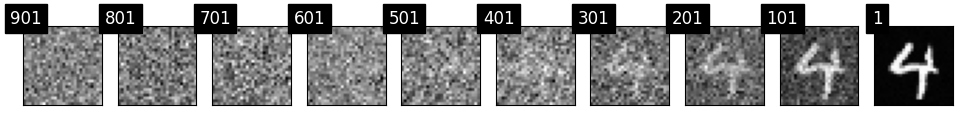

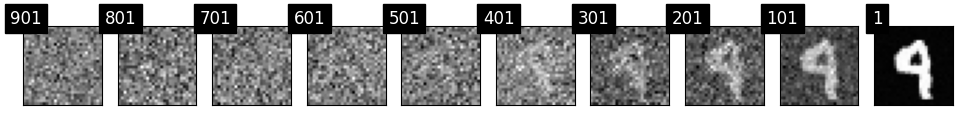

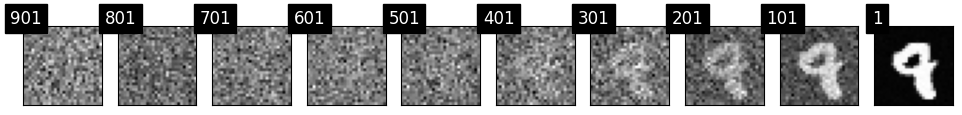

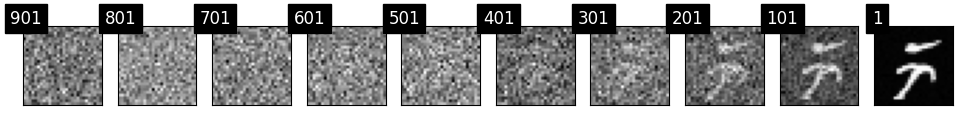

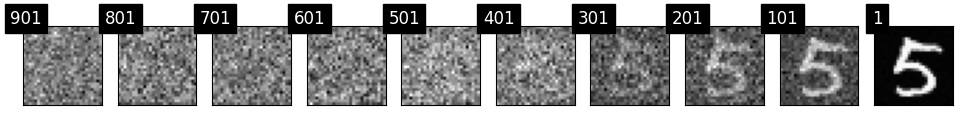

In [49]:
for i in range(5):
    images_ = torch.stack(images[i], dim=0)
    show_sample(images_, texts[i])